In [24]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score,confusion_matrix

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from lightgbm import LGBMModel,LGBMClassifier

from sklearn.ensemble import RandomForestRegressor

import catboost as cb

In [2]:
train_df= pd.read_csv('.../train_yaOffsB.csv')
test_df= pd.read_csv('.../test_pFkWwen.csv')

In [3]:
# data types
pd.DataFrame({'Type_Train':train_df.dtypes,'Type_Test':test_df.dtypes})

,Type_Train,Type_Test
Crop_Damage,int64,NaN
Crop_Type,int64,int64
Estimated_Insects_Count,int64,int64
ID,object,object
Number_Doses_Week,int64,int64
Number_Weeks_Quit,int64,int64
Number_Weeks_Used,float64,float64
Pesticide_Use_Category,int64,int64
Season,int64,int64
Soil_Type,int64,int64


In [4]:
train_df['train_or_test']='train'
test_df['train_or_test']='test'
df=pd.concat([train_df,test_df])

In [5]:
# missing values treatment
def nan_check(data):
    total= data.isnull().sum().sort_values(ascending= False)
    percentage_1= data.isnull().sum()/data.isnull().count()*100
    percentage_2= (np.round(percentage_1,1)).sort_values(ascending= False)
    missing_data= pd.concat([total,percentage_2], axis=1, keys= ['Total','%'])
    return missing_data
print(nan_check(df))

                         Total     %
Crop_Damage              59310  40.0
Number_Weeks_Used        14893  10.1
train_or_test                0   0.0
Soil_Type                    0   0.0
Season                       0   0.0
Pesticide_Use_Category       0   0.0
Number_Weeks_Quit            0   0.0
Number_Doses_Week            0   0.0
ID                           0   0.0
Estimated_Insects_Count      0   0.0
Crop_Type                    0   0.0


In [6]:
# correlation
df.corr()

,Crop_Damage,Crop_Type,Estimated_Insects_Count,Number_Doses_Week,Number_Weeks_Quit,Number_Weeks_Used,Pesticide_Use_Category,Season,Soil_Type
Crop_Damage,1.000000,-0.016495,0.202888,-0.030874,-0.133117,0.232192,0.175002,-0.000184,-0.021997
Crop_Type,-0.016495,1.000000,-0.090363,-0.191225,-0.234154,-0.044251,0.234132,0.002445,-0.289331
Estimated_Insects_Count,0.202888,-0.090363,1.000000,-0.102897,0.299628,0.435800,-0.082212,-0.001141,-0.056379
Number_Doses_Week,-0.030874,-0.191225,-0.102897,1.000000,-0.038623,0.126811,-0.000223,-0.000210,0.079209
Number_Weeks_Quit,-0.133117,-0.234154,0.299628,-0.038623,1.000000,-0.447658,-0.552969,0.001636,0.009091
Number_Weeks_Used,0.232192,-0.044251,0.435800,0.126811,-0.447658,1.000000,0.344317,0.001317,-0.068448
Pesticide_Use_Category,0.175002,0.234132,-0.082212,-0.000223,-0.552969,0.344317,1.000000,-0.000078,0.034108
Season,-0.000184,0.002445,-0.001141,-0.000210,0.001636,0.001317,-0.000078,1.000000,0.000163
Soil_Type,-0.021997,-0.289331,-0.056379,0.079209,0.009091,-0.068448,0.034108,0.000163,1.000000


In [7]:
df.reset_index(inplace=True)

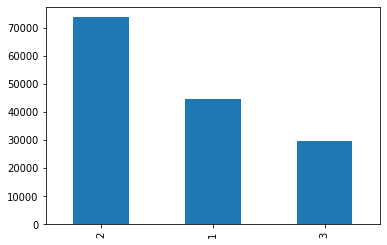

In [8]:
df.Season.value_counts().plot('bar')

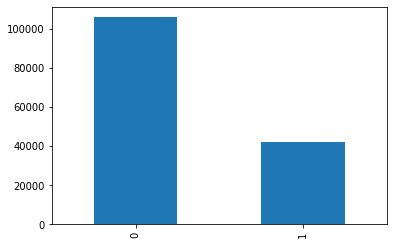

In [9]:
df.Crop_Type.value_counts().plot('bar')

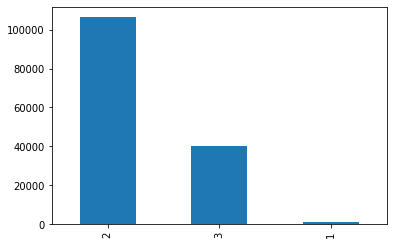

In [10]:
df.Pesticide_Use_Category.value_counts().plot('bar')

In [11]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

In [12]:

train['Number_Weeks_Used'].fillna((train['Number_Weeks_Used'].mean()), inplace=True)
test['Number_Weeks_Used'].fillna((test['Number_Weeks_Used'].mean()), inplace=True)

In [13]:
y=train.loc[:,['Crop_Damage']]
train=train[['Crop_Type','Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Quit','Number_Weeks_Used',
               'Pesticide_Use_Category','Season','Soil_Type']]

# Y=train.loc[:,['Crop_Damage']]

X_eval=test[['Crop_Type','Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Quit','Number_Weeks_Used','Pesticide_Use_Category','Season','Soil_Type']]
train.shape, X_eval.shape

((88858, 8), (59310, 8))

In [14]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train, y, test_size=0.2)

In [15]:
# data scaling
col=X_train.columns
from sklearn.preprocessing import StandardScaler
st=StandardScaler()
st.fit(X_train)
X_train=st.transform(X_train)
X_test=st.transform(X_test)
validation=st.transform(X_eval)

In [21]:
# Random Forest
rf=RandomForestRegressor(n_estimators=500,max_depth=6, n_jobs=4)
rf.fit(X_train,Y_train)
y_pred_rf=rf.predict(X_test)
predictions_rf = [round(value) for value in y_pred_rf]
print(confusion_matrix(Y_test,predictions_rf))
print("Precision = {}".format(precision_score(Y_test, predictions_rf, average='macro')))
print("Recall = {}".format(recall_score(Y_test, predictions_rf, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, predictions_rf)))

[[14274   626     0]
 [ 1897   519     0]
 [  265   191     0]]
Precision = 0.41897751102807773
Recall = 0.39093481932530333
Accuracy = 0.8323767724510466


In [30]:
# XG Boost
xgb=XGBClassifier( booster='gbtree', colsample_bylevel=1, colsample_bytree=0.8, gamma=1.5, 
                  learning_rate=0.01, max_delta_step=0, max_depth=7, min_child_weight=0, missing=None, 
                  n_estimators=200, n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0, 
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=0.8)
xgb.fit(X_train,Y_train)
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(Y_test,predictions))
print("Precision = {}".format(precision_score(Y_test, predictions, average='macro')))
print("Recall = {}".format(recall_score(Y_test, predictions, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, predictions)))


pred=xgb.predict(validation)
final_predictions = [round(value) for value in pred]

output_df= pd.DataFrame({'ID': test['ID'].values})
output_df['Crop_Damage']= final_predictions
output_df.to_csv('.../xgb.csv',index=False)

[[14795   105     0]
 [ 2167   249     0]
 [  366    90     0]]
Precision = 0.4715437390298886
Recall = 0.3653386446805043
Accuracy = 0.8465001125365744


In [29]:
# Light GBM
Lgb = LGBMClassifier(n_estimators=90, silent=False, random_state =0, max_depth=5,num_leaves=31)

Lgb.fit(X_train,Y_train)
y_pred_lgb = Lgb.predict(X_test)
predictions_lgb = [round(value) for value in y_pred_lgb]
print(confusion_matrix(Y_test,predictions_lgb))
print("Precision = {}".format(precision_score(Y_test, predictions_lgb, average='macro')))
print("Recall = {}".format(recall_score(Y_test, predictions_lgb, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, predictions_lgb)))

pred_lgb=Lgb.predict(validation)
final_prediction_lgb = [round(value) for value in pred_lgb]

output_df1= pd.DataFrame({'ID': test['ID'].values})
output_df1['Crop_Damage']= final_predictions
output_df1.to_csv('.../lgb.csv',index=False)

[[14701   199     0]
 [ 2060   356     0]
 [  333   123     0]]
Precision = 0.46169436877401476
Recall = 0.37799842955983226
Accuracy = 0.8472316002700878


In [31]:
merge_df= pd.merge(output_df, output_df1, on= 'ID', how= 'inner')
#pd.concat([output_df, output_df3]).groupby(level=0).mean()
merge_df['avg_Crop_Damage']= (merge_df.Crop_Damage_x + merge_df.Crop_Damage_y)/2
output_df4= pd.DataFrame({'ID': test_df['ID'].values})
output_df4['Crop_Damage']= merge_df['avg_Crop_Damage']
output_df4.to_csv('.../5th.csv', index=False)